In [114]:
# import numpy as np
import pandas as pd
from autogluon.tabular import TabularPredictor, TabularDataset
# from joblib import cpu_count

import sys
sys.path.append("../scripts")

from split_data import split_data

In [115]:
predict_df = pd.read_csv("../data/clean/predict_df.csv", header=[0, 1], index_col=0)

In [116]:
# Subset to ys suitable for classification problem
predict_df = predict_df.drop(columns=('X', 'measurement_idx'))

In [117]:
problem_df = predict_df[[('y_class', 'do_in_range')] + predict_df[['X']].columns.tolist() + predict_df[['group']].columns.tolist()]
problem_df = problem_df[problem_df[('y_class', 'do_in_range')].notnull()]

train_idx, test_idx = split_data(problem_df, split_type='stratified', stratify_column=('y_class', 'do_in_range'), random_state=45)
problem_df = problem_df.drop(columns='group', level=0)
problem_df.columns = problem_df.columns.droplevel(0)

len(train_idx), len(test_idx)

(3901, 976)

In [118]:
train_data = TabularDataset(problem_df.iloc[train_idx])
test_data = TabularDataset(problem_df.iloc[test_idx])

In [119]:
predictor = TabularPredictor(label='do_in_range').fit(train_data, presets='good_quality')

No path specified. Models will be saved in: "AutogluonModels\ag-20250102_191235"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       13.76 GB / 31.35 GB (43.9%)
Disk Space Avail:   39.36 GB / 471.56 GB (8.3%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). AutoGluon wil

In [124]:
print(f"Best model: {predictor.model_best}")
predictor.evaluate(test_data, detailed_report=True)

Best model: NeuralNetTorch_BAG_L1_FULL


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

{'accuracy': 0.8247950819672131,
 'balanced_accuracy': 0.3861726256008567,
 'mcc': 0.21978769771976298,
 'confusion_matrix':         above  below  within
 above       0      2      33
 below       0     26     112
 within      0     24     779,
 'classification_report': {'above': {'precision': 0.0,
   'recall': 0.0,
   'f1-score': 0.0,
   'support': 35.0},
  'below': {'precision': 0.5,
   'recall': 0.18840579710144928,
   'f1-score': 0.2736842105263158,
   'support': 138.0},
  'within': {'precision': 0.8430735930735931,
   'recall': 0.9701120797011208,
   'f1-score': 0.9021424435437174,
   'support': 803.0},
  'accuracy': 0.8247950819672131,
  'macro avg': {'precision': 0.4476911976911977,
   'recall': 0.3861726256008567,
   'f1-score': 0.39194221802334445,
   'support': 976.0},
  'weighted avg': {'precision': 0.7643320647931304,
   'recall': 0.8247950819672131,
   'f1-score': 0.7809311508383573,
   'support': 976.0}}}

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay

In [126]:
model = make_pipeline(
  StandardScaler(),
  RandomForestClassifier(n_estimators=100, random_state=0)
)
model.fit(train_data.drop(columns='do_in_range'), train_data['do_in_range'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

Accuracy: 0.8114754098360656


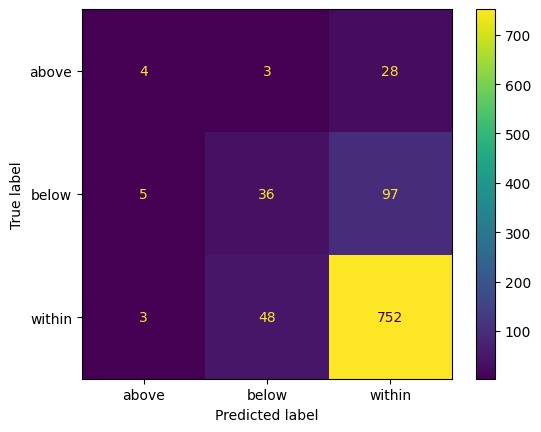

In [127]:
y_pred = model.predict(test_data.drop(columns='do_in_range'))
print(f"Accuracy: {model.score(test_data.drop(columns='do_in_range'), test_data['do_in_range'])}")

ConfusionMatrixDisplay.from_estimator(model, test_data.drop(columns='do_in_range'), test_data['do_in_range'])